# Style Transfer with Convolutional Neural Networks

In [1]:
import torchvision.models as models
from importlib import reload
import torch
import numpy as np
from torch.optim import LBFGS
import torch.nn as nn
from __future__ import print_function
import utils as U;reload(U)
from torch.autograd import Variable
import torch.optim as optim
import torch.autograd as autograd

import matplotlib.pyplot as plt
import pdb
import copy

%matplotlib inline

In [2]:
vgg = models.vgg16(pretrained=True)

In [16]:
vgg_convolutional_indexes = [ i for i, layer in enumerate(vgg.features) if type(layer) == nn.Conv2d ] 
print(vgg_convolutional_indexes)

[0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]


## Content Loss

### Content Image

# Content Loss

In [3]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()        
        self.target = target.detach()
        self.loss_fn = nn.MSELoss()
    
    def forward(self, input):
        self.loss = self.loss_fn(input, self.target)
        self.output = input.clone()
        return self.output
    
    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss


<PIL.Image.Image image mode=RGB size=224x224 at 0x7F9FFC47B2B0>


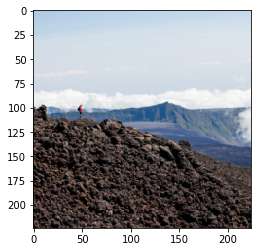

In [4]:
content_image = Variable(U.get_image(4, None, 112))
content_image = content_image.cuda()
U.imshow(content_image.data)

In [5]:
def build_model(cnn, convolutional_loss_layers):
    content_losses = []
    model = nn.Sequential()
    cnn = copy.deepcopy(cnn).cuda()
    for index, layer in enumerate(cnn.features):
        layer_set = False   
        if type(layer) is nn.ReLU:
            layer_set = True
            model.add_module("layer_{}_relu".format(index ), layer)
            
            if index - 1 in convolutional_loss_layers:
                content_target = model(content_image.unsqueeze(0)).clone()
                content_loss = ContentLoss(content_target)
                content_losses.append(content_loss)
                model.add_module("layer_{}_content_loss_relu".format(index), content_loss)
                        

        if type(layer) is nn.MaxPool2d:
            layer_set = True
            avg_pool = nn.AvgPool2d(kernel_size=layer.kernel_size, stride=layer.stride, padding = layer.padding)
            model.add_module("layer_{}".format(index), avg_pool)
        if not layer_set:
            model.add_module("layer_{}".format(index), layer)
    modeul = model.cuda()
    return model, content_losses

In [64]:
import pdb
class Runner():
    def __init__(self, model, optimizer, c_losses, gen_image, print_every=100):
        self.optimizer = optimizer
        self.model = model
        self.c_losses = c_losses
        self.gen_image = gen_image
        self.count = 0
        self.content_loss = 0
        self.print_every = print_every

    def loss_fn(self):
        self.gen_image.data.clamp_(0,1)
        self.optimizer.zero_grad()
        self.count += 1
        prediction = self.gen_image.unsqueeze(0)
        model(prediction)
        
        c_loss = 0
        for c in self.c_losses:
            c_loss += c.backward()

        self.content_loss = c_loss
        flattened_img = self.gen_image.grad.view(self.gen_image.nelement()).data            
        max_grad = flattened_img.max()
        min_grad = flattened_img.min()
        if self.count % self.print_every == 0:
            print("Iteration: {} Loss: {} Gradient Range: ({}...{})".format(self.count,c_loss.data[0], min_grad, max_grad))
        return self.content_loss


In [59]:
def run_epochs(count, runner, print_every= 20):
    for i in range(count):
        ttl_loss = runner.optimizer.step(runner.loss_fn).data[0]
        content_loss = runner.content_loss[0].data[0]
        if i % print_every == 0:
            print("Epoch #{} Content Loss: {}".format(str(i), content_loss, ttl_loss))
    runner.gen_image.data.clamp_(0,1)

In [67]:
def run_epochs_sgd(count, runner, print_every= 20):
    for i in range(count):
        runner.loss_fn()
        ttl_loss = runner.optimizer.step()
        content_loss = runner.content_loss[0].data[0]
        if i % print_every == 0:
            print("Epoch #{} Content Loss: {}".format(str(i), content_loss, ttl_loss))
    runner.gen_image.data.clamp_(0,1)

In [33]:
def random_image():
    noise_tensor = torch.rand(3,224, 224)
    gen_image = nn.Parameter(noise_tensor)
    gen_image = gen_image.cuda().clone().detach()
    gen_image.requires_grad = True
    return gen_image

# BFLGS BUG? Gradients Are moving in the wrong direction

In [89]:
model, content_losses = build_model(vgg, vgg_convolutional_indexes[0:6])
image = random_image()

optim = LBFGS([image], lr=0.1)
runner = Runner(model, optim, content_losses, image, print_every = 50)
run_epochs(200, runner)

Epoch #0 Content Loss: 1.0430333614349365
Iteration: 50 Loss: 0.2732812762260437 Gradient Range: (-0.0006076728459447622...0.0004988270811736584)
Iteration: 100 Loss: 0.10930372774600983 Gradient Range: (-0.00023763440549373627...0.0002341990766581148)
Iteration: 150 Loss: 0.06244435906410217 Gradient Range: (-8.930721378419548e-05...9.208233677782118e-05)
Iteration: 200 Loss: 0.04302961751818657 Gradient Range: (-7.648266910109669e-05...6.573995051439852e-05)
Iteration: 250 Loss: 0.03317323699593544 Gradient Range: (-4.130438173888251e-05...7.190370524767786e-05)
Iteration: 300 Loss: 0.027419263496994972 Gradient Range: (-3.07141563098412e-05...6.851184298284352e-05)
Iteration: 350 Loss: 0.02391199953854084 Gradient Range: (-3.250889858463779e-05...6.069232040317729e-05)
Iteration: 400 Loss: 0.020966261625289917 Gradient Range: (-2.9379230909398757e-05...5.864362174179405e-05)
Epoch #20 Content Loss: 0.019739937037229538
Iteration: 450 Loss: 0.017761141061782837 Gradient Range: (-3.24

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F9FC80DDEF0>


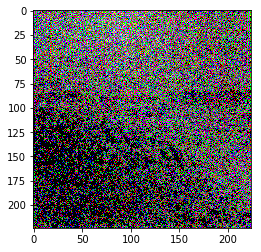

In [92]:
U.imshow(image.data)

# With SGD

In [93]:
model, content_losses = build_model(vgg, vgg_convolutional_indexes[0:6])
image = random_image()

optim = torch.optim.SGD([image], lr=3)
runner = Runner(model, optim, content_losses, image, print_every = 1000)
run_epochs_sgd(12000, runner, print_every =1000)

Epoch #0 Content Loss: 5.550586223602295
Iteration: 1000 Loss: 0.18538060784339905 Gradient Range: (-0.00016009941464290023...0.00022218911908566952)
Epoch #1000 Content Loss: 0.18514153361320496
Iteration: 2000 Loss: 0.08748284727334976 Gradient Range: (-9.685846453066915e-05...0.00010902895155595616)
Epoch #2000 Content Loss: 0.08744385093450546
Iteration: 3000 Loss: 0.06362012773752213 Gradient Range: (-5.006489300285466e-05...5.780963692814112e-05)
Epoch #3000 Content Loss: 0.06360543519258499
Iteration: 4000 Loss: 0.05273543298244476 Gradient Range: (-4.874006117461249e-05...3.572515561245382e-05)
Epoch #4000 Content Loss: 0.05272751301527023
Iteration: 5000 Loss: 0.046317316591739655 Gradient Range: (-3.209471105947159e-05...2.8869713787571527e-05)
Epoch #5000 Content Loss: 0.04631213843822479
Iteration: 6000 Loss: 0.04194250330328941 Gradient Range: (-3.2431562431156635e-05...2.8331756766419858e-05)
Epoch #6000 Content Loss: 0.04193880036473274
Iteration: 7000 Loss: 0.0386895909

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F9FC82A4F60>


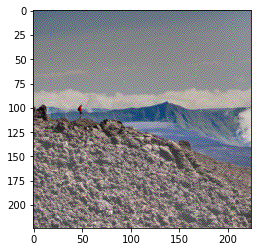

In [94]:
U.imshow(image.data)

# Layer 0

## LBFGS

In [57]:
model, content_losses = build_model(vgg, vgg_convolutional_indexes[0:6])
image = random_image()

optim = LBFGS([image], lr=0.1)
runner = Runner(model, optim, content_losses, image)
run_epochs(60, runner)

Epoch #0 Content Loss: 0.09543481469154358
Iteration: 100 Loss: 0.09540796279907227 Grads: (-2.0334695363999344e-05...1.9715946109499782e-05)
Iteration: 200 Loss: 0.0953744500875473 Grads: (-2.032796328421682e-05...1.9709636035258882e-05)
Iteration: 300 Loss: 0.09534092247486115 Grads: (-2.0321240299381316e-05...1.9703329598996788e-05)
Iteration: 400 Loss: 0.09530741721391678 Grads: (-2.0314520952524617e-05...1.969702134374529e-05)
Epoch #20 Content Loss: 0.09530071169137955
Iteration: 500 Loss: 0.0952739343047142 Grads: (-2.0307794329710305e-05...1.9690713088493794e-05)
Iteration: 600 Loss: 0.09524044394493103 Grads: (-2.0301078620832413e-05...1.9684404833242297e-05)
Iteration: 700 Loss: 0.09520698338747025 Grads: (-2.0294370187912136e-05...1.96780965779908e-05)
Iteration: 800 Loss: 0.09517353773117065 Grads: (-2.028766175499186e-05...1.967179196071811e-05)
Epoch #40 Content Loss: 0.09516683965921402
Iteration: 900 Loss: 0.09514009952545166 Grads: (-2.0280949684092775e-05...1.96654873

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F9FC82BB0B8>


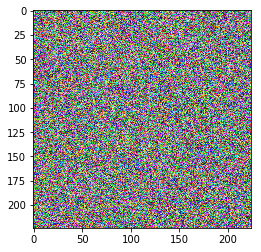

In [58]:
U.imshow(image.data)

## SGD

In [88]:
model, content_losses = build_model(vgg, vgg_convolutional_indexes[:1])
image = random_image()

optim = torch.optim.SGD([image], lr=10)
runner = Runner(model, optim, content_losses, image, print_every = 1000)
run_epochs_sgd(12000, runner, print_every =1000)

Epoch #0 Content Loss: 5.573806285858154
Iteration: 1000 Loss: 0.05972130969166756 Gradient Range: (-6.465615297202021e-05...5.947721001575701e-05)
Epoch #1000 Content Loss: 0.05968158319592476
Iteration: 2000 Loss: 0.03989405184984207 Gradient Range: (-3.651577571872622e-05...4.9849095375975594e-05)
Epoch #2000 Content Loss: 0.03988374024629593
Iteration: 3000 Loss: 0.03254467248916626 Gradient Range: (-2.9096378057147376e-05...4.2959545680787414e-05)
Epoch #3000 Content Loss: 0.032539382576942444
Iteration: 4000 Loss: 0.028361234813928604 Gradient Range: (-3.530224057612941e-05...3.7161931686569005e-05)
Epoch #4000 Content Loss: 0.02835780382156372
Iteration: 5000 Loss: 0.0254948902875185 Gradient Range: (-2.351806870137807e-05...3.919921437045559e-05)
Epoch #5000 Content Loss: 0.025492407381534576
Iteration: 6000 Loss: 0.023305624723434448 Gradient Range: (-2.2710839402861893e-05...3.655278487713076e-05)
Epoch #6000 Content Loss: 0.0233036857098341
Iteration: 7000 Loss: 0.0215196162

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F9FC8121A20>


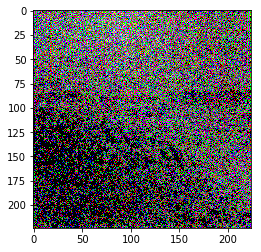

In [91]:
U.imshow(image.data)

# Layer 2

In [36]:
model, content_losses = build_model(vgg, vgg_convolutional_indexes[1:2])
image = random_image()

optim = LBFGS([image], lr=0.1)
runner = Runner(model, optim, content_losses, image)
run_epochs(50, runner)

Epoch #0 Content Loss: 0.023480065166950226
Iteration: 100 Loss: 0.0021865786984562874 Grads: (-3.7706424791394966e-06...5.496892299561296e-06)
Iteration: 200 Loss: 7.392224506475031e-05 Grads: (-1.8984359257956385e-06...4.7431958591914736e-06)
Iteration: 300 Loss: 0.7086333632469177 Grads: (-0.00020198483252897859...0.00020026316633448005)
Epoch #20 Content Loss: 0.8406288623809814
Epoch #40 Content Loss: 0.8406288623809814


<PIL.Image.Image image mode=RGB size=224x224 at 0x7F9FC83C56A0>


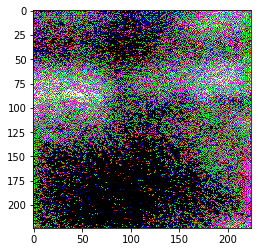

In [37]:
U.imshow(image.data)


# Layer 5

In [38]:
model, content_losses = build_model(vgg, vgg_convolutional_indexes[2:3])
image = random_image()

optim = LBFGS([image], lr=0.1)
runner = Runner(model, optim, content_losses, image)
run_epochs(50, runner)

Epoch #0 Content Loss: 0.05598192289471626
Iteration: 100 Loss: 0.005210852716118097 Grads: (-6.57811870041769e-06...7.340182492043823e-06)
Iteration: 200 Loss: 0.0030266374815255404 Grads: (-6.243507414183114e-06...1.0024244147643913e-05)
Iteration: 300 Loss: 0.0016695046797394753 Grads: (-8.178985808626749e-06...1.000994598143734e-05)
Iteration: 400 Loss: 0.0004173644701950252 Grads: (-6.7333990045881364e-06...6.660339295194717e-06)
Epoch #20 Content Loss: 0.00030856981175020337
Iteration: 500 Loss: 0.0001802224578568712 Grads: (-1.5398267123600817e-06...1.419744535269274e-06)
Iteration: 600 Loss: 0.00014785409439355135 Grads: (-1.0616732879498159e-06...1.8535546359998989e-06)
Iteration: 700 Loss: 0.0004383529012557119 Grads: (-1.4545770682161674e-05...1.9503846488078125e-05)
Iteration: 800 Loss: 0.00035304311313666403 Grads: (-8.678604899614584e-06...3.363361884112237e-06)
Epoch #40 Content Loss: 0.000253691483521834
Iteration: 900 Loss: 0.00011717921734089032 Grads: (-1.55840973548

<PIL.Image.Image image mode=RGB size=224x224 at 0x7F9FC83C1A90>


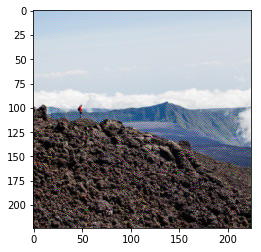

In [39]:
U.imshow(image.data)